In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-realized-volatility-prediction/sample_submission.csv
/kaggle/input/optiver-realized-volatility-prediction/train.csv
/kaggle/input/optiver-realized-volatility-prediction/test.csv
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=97/888f813404d8417ca8d6b8aebd5f2951.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=43/bb0efa57f511470e817880842e3e2afa.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=21/1d8dc18ebfee47ffbb54b04e6afc0634.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=72/60f62a03d8854605901dda072c84db39.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=4/761268d671f9429abb29d9d2895e9bd2.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=112/cd283097a5b54293ba400a19e811a7f9.parquet
/kaggle/input/optiver-realized-volatility-pr

In [2]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings

In [3]:
data_dir = '../input/optiver-realized-volatility-prediction/'
# data_dir = 'C:/Users/User/Desktop/ORVP/'
train = pd.read_csv(data_dir+'train.csv')
test = pd.read_csv(data_dir+'test.csv')
train1 = pd.read_csv(data_dir+'train.csv')

In [4]:
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap
def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))
def pressure_compute(df):
    sell_percent_with_mid_price1 = df["mid_price1"]/(df["mid_price1"]-df['ask_price1'])
    sell_percent_with_mid_price2 = df["mid_price1"]/(df["mid_price1"]-df['ask_price2'])
    buy_percent_with_mid_price1 = df["mid_price1"]/(df["mid_price1"]-df['bid_price1'])
    buy_percent_with_mid_price2 = df["mid_price1"]/(df["mid_price1"]-df['bid_price2'])
    sell_pressure = sell_percent_with_mid_price1/sell_percent_with_mid_price1.sum()*df['ask_size1']+ sell_percent_with_mid_price2/sell_percent_with_mid_price2.sum()*df['ask_size2']
    buy_pressure = buy_percent_with_mid_price1/buy_percent_with_mid_price1.sum()*df['bid_size1'] + buy_percent_with_mid_price2/buy_percent_with_mid_price2.sum()*df['bid_size2']
    pressure_ratio = np.log(sell_pressure) - np.log(buy_pressure)
    return sell_pressure, buy_pressure, pressure_ratio
def count_unique(series):
    return len(np.unique(series))
def read_train_test():   
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test
def RSV_10min(df):
  minest = df['wap1'].min()
  maxest = df['wap1'].max()
  last_price = df.iloc[-1]['wap1']
  RSV_10min = (last_price - minest) / (maxest - minest)
  return RSV_10min
def get_kd_v1(df):
  K_bef = D_bef = 50
  bef_minest = df[:len(df.index)//2]['wap1'].min()
  bef_maxest = df[:len(df.index)//2]['wap1'].max()
  bef_last_price = df.iloc[len(df.index)//2]['wap1']

  RSV_bef = (bef_last_price - bef_minest) / (bef_maxest - bef_minest)
  K_bef = 2/3*K_bef + 1/3*RSV_bef
  D_bef = 2/3*D_bef + 1/3*K_bef

  aft_minest = df[len(df.index)//2:]['wap1'].min()
  aft_maxest = df[len(df.index)//2:]['wap1'].max()
  aft_last_price = df.iloc[-1]['wap1']
  RSV_bef = (aft_last_price - aft_minest) / (aft_maxest - aft_minest)
  K_bef = 2/3*K_bef + 1/3*RSV_bef
  D_bef = 2/3*D_bef + 1/3*K_bef

  return K_bef, D_bef

def get_kd_v2(df):
  K_bef = D_bef = 50 
  bef_minest = df[:len(df.index)//3]['wap1'].min()
  bef_maxest = df[:len(df.index)//3]['wap1'].max()
  bef_last_price = df.iloc[len(df.index)//3]['wap1']

  RSV_bef = (bef_last_price - bef_minest) / (bef_maxest - bef_minest)
  K_bef = 2/3*K_bef + 1/3*RSV_bef
  D_bef = 2/3*D_bef + 1/3*K_bef

  bef_minest = df[len(df.index)//3 : len(df.index)*2//3]['wap1'].min()
  bef_maxest = df[len(df.index)//3:len(df.index)*2//3]['wap1'].max()
  bef_last_price = df.iloc[len(df.index)*2//3]['wap1']

  RSV_bef = (bef_last_price - bef_minest) / (bef_maxest - bef_minest)
  K_bef = 2/3*K_bef + 1/3*RSV_bef
  D_bef = 2/3*D_bef + 1/3*K_bef

  bef_minest = df[len(df.index)*2//3:]['wap1'].min()
  bef_maxest = df[len(df.index)*2//3:]['wap1'].max()
  bef_last_price = df.iloc[-1]['wap1']

  RSV_bef = (bef_last_price - bef_minest) / (bef_maxest - bef_minest)
  K_bef = 2/3*K_bef + 1/3*RSV_bef
  D_bef = 2/3*D_bef + 1/3*K_bef
  
  return K_bef, D_bef
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

# OBV能量潮指標(On Balance Volume)
def OBV(df):
  
  # 前五分鐘總量
  bef_volume = df[:len(df.index)//2]['size'].sum()


  # 後五分鐘總量
  aft_volume = df[len(df.index)//2:]['size'].sum()

  OBV = aft_volume - bef_volume


  return OBV

def get_BBands_difference(df):
  # 中位數
  SMA = df[:len(df.index)]['wap1'].mean()
  SMA_std = np.std(df[:len(df.index)]['wap1'])
  BBands_up = SMA + SMA_std*2
  BBands_down = SMA - SMA_std*2

  BBands_difference = BBands_up - BBands_down
  return BBands_difference

In [5]:
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    ##Price 
    ##(1) Weighted Price
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df)
    df['wap4'] = calc_wap4(df)

    df['log_return1'] = df.groupby('time_id')['wap1'].apply(log_return)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)

    ##(2) middle price 
    df["mid_price1"] = (df['ask_price1'] + df['bid_price1'])/2

    ##(3)price spread 
    df['price_spread1'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)

    ##(4) volume spread 
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])

    ##(5) imbalance 
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    df["relative_wap_balance"] = (df['wap1'] - df['wap2'])/( df['wap1'] + df['wap2'])

    ##(6) Volume imbalance 
    df['depth_imbalance1'] = (df['ask_size1'] - df["bid_size1"])/(df['ask_size1'] + df["bid_size1"])
    df['depth_imbalance2'] = (df['ask_size2'] - df["bid_size2"])/(df['ask_size2'] + df["bid_size2"])
  
    ##(7)volume imbalance 
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])

    ##(8)pressure
    df['sell_pressure'], df['buy_pressure'], df['pressure_ratio'] = pressure_compute(df)


    df['rsv'] = RSV_10min(df)
    df['K_value'], df['D_value'] = get_kd_v2(df)
    df['BBands'] = get_BBands_difference(df)

    create_feature_dict = {
        'wap1': [np.sum, np.max, np.min, np.mean, np.std],
        'wap2': [np.sum, np.max, np.min, np.mean, np.std],
        'wap3': [np.sum, np.max, np.min, np.mean, np.std],
        'wap4': [np.sum, np.max, np.min, np.mean, np.std],
        
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        
        'price_spread1':[np.sum, np.max, np.min, np.mean, np.std],
        'price_spread2':[np.sum, np.max, np.min, np.mean, np.std],

        'bid_spread':[np.sum, np.max, np.min, np.mean, np.std],
        'ask_spread':[np.sum, np.max, np.min, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.max, np.min, np.mean, np.std],

        'wap_balance': [np.sum, np.max, np.min, np.mean, np.std],
        "relative_wap_balance":[np.sum, np.max, np.min, np.mean, np.std],

        'total_volume':[np.sum, np.max, np.min, np.mean, np.std],
        'sell_pressure':[np.sum, np.max, np.min, np.mean, np.std, realized_volatility],
        'buy_pressure':[np.sum, np.max, np.min, np.mean, np.std, realized_volatility],
        'pressure_ratio':[np.sum, np.max, np.min, np.mean, np.std, realized_volatility],


    }
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
        'sell_pressure':[realized_volatility],
        'buy_pressure':[realized_volatility],
        'pressure_ratio':[realized_volatility],
    }

    
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(cf_dict, seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(cf_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict, seconds_in_bucket = 0, add_suffix = False)
    #df_feature_60 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 60, add_suffix = True)
    #df_feature_120 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 120, add_suffix = True)
    #df_feature_180 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 180, add_suffix = True)
    df_feature_240 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 240, add_suffix = True)
    #df_feature_300 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 300, add_suffix = True)
    #df_feature_360 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 360, add_suffix = True)
    #df_feature_420 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 420, add_suffix = True)
    df_feature_480 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 480, add_suffix = True)
    #df_feature_540 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 540, add_suffix = True)


    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id] 
        rsv_min = RSV_10min(df_id)
#         K_bef1, D_bef1 = get_kd_v1(df_id)
        K_bef2, D_bef2 = get_kd_v2(df_id)
        BBands = get_BBands_difference(df_id)
        lis.append({'time_id':n_time_id,
              'RSV_10min':rsv_min,
#               'K_bef1':K_bef1, 
#               'D_bef1':D_bef1,
              'K_bef2':K_bef2, 
              'D_bef2':D_bef2,
              'BBands':BBands,
              })
    df_lr = pd.DataFrame(lis)       
   
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')

    # Merge all
    #df_feature = df_feature.merge(df_feature_60, how = 'left', left_on = 'time_id_', right_on = 'time_id__60')
    #df_feature = df_feature.merge(df_feature_120, how = 'left', left_on = 'time_id_', right_on = 'time_id__120')
    #df_feature = df_feature.merge(df_feature_180, how = 'left', left_on = 'time_id_', right_on = 'time_id__180')
    df_feature = df_feature.merge(df_feature_240, how = 'left', left_on = 'time_id_', right_on = 'time_id__240')
    #df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    #df_feature = df_feature.merge(df_feature_360, how = 'left', left_on = 'time_id_', right_on = 'time_id__360')
    #df_feature = df_feature.merge(df_feature_420, how = 'left', left_on = 'time_id_', right_on = 'time_id__420')
    df_feature = df_feature.merge(df_feature_480, how = 'left', left_on = 'time_id_', right_on = 'time_id__480')
    #df_feature = df_feature.merge(df_feature_540, how = 'left', left_on = 'time_id_', right_on = 'time_id__540')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__240','time_id__480'], axis = 1, inplace = True)

    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    df_feature.drop(['time_id'], axis = 1, inplace = True)
    return df_feature

In [6]:
# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']

    df['obv'] = OBV(df)
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility, np.max, np.min, np.std],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min, np.mean, np.std],
        'order_count':[np.sum, np.max, np.min, np.mean, np.std],
        'amount':[np.sum, np.max, np.min, np.mean, np.std],
    }
    create_feature_dict_time = {
        'log_return':[realized_volatility, np.sum, np.max, np.min, np.mean, np.std],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min, np.mean, np.std],
        'order_count':[np.sum, np.max, np.min, np.mean, np.std],
        'amount':[np.sum, np.max, np.min, np.mean, np.std],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(cf_dict, seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(cf_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict, seconds_in_bucket = 0, add_suffix = False)
    #df_feature_60 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 60, add_suffix = True)
    #df_feature_120 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 120, add_suffix = True)
    #df_feature_180 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 180, add_suffix = True)
    df_feature_240 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 240, add_suffix = True)
    #df_feature_300 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 300, add_suffix = True)
    #df_feature_360 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 360, add_suffix = True)
    #df_feature_420 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 420, add_suffix = True)
    df_feature_480 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 480, add_suffix = True)
    #df_feature_540 = get_stats_window(create_feature_dict_time, seconds_in_bucket = 540, add_suffix = True)

    def tendency(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return (power)
    
    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]        
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)      
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)

        # PoV(Percent of Volume)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))        
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)
        
        # vol vars    
        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))        
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)
        
        obv = OBV(df)

        lis.append({'time_id':n_time_id,
              'tendency':tendencyV,
              'f_max':f_max,
              'f_min':f_min,
              'df_max':df_max,
              'df_min':df_min,
              'abs_diff':abs_diff,
              'energy':energy,
              'iqr_p':iqr_p,
              'abs_diff_v':abs_diff_v,
              'energy_v':energy_v,
              'iqr_p_v':iqr_p_v,
               'obv':obv })

    df_lr = pd.DataFrame(lis)
        
   
#     df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')
    
    # Merge all
    #df_feature = df_feature.merge(df_feature_60, how = 'left', left_on = 'time_id_', right_on = 'time_id__60')
    #df_feature = df_feature.merge(df_feature_120, how = 'left', left_on = 'time_id_', right_on = 'time_id__120')
    #df_feature = df_feature.merge(df_feature_180, how = 'left', left_on = 'time_id_', right_on = 'time_id__180')
    df_feature = df_feature.merge(df_feature_240, how = 'left', left_on = 'time_id_', right_on = 'time_id__240')
    #df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    #df_feature = df_feature.merge(df_feature_360, how = 'left', left_on = 'time_id_', right_on = 'time_id__360')
    #df_feature = df_feature.merge(df_feature_420, how = 'left', left_on = 'time_id_', right_on = 'time_id__420')
    df_feature = df_feature.merge(df_feature_480, how = 'left', left_on = 'time_id_', right_on = 'time_id__480')
    #df_feature = df_feature.merge(df_feature_540, how = 'left', left_on = 'time_id_', right_on = 'time_id__540')

    # Drop unnecesary time_ids
    df_feature.drop(['time_id__240','time_id__480'], axis = 1, inplace = True)

    
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

In [7]:
# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 
            #'log_return1_realized_volatility_60', 'log_return2_realized_volatility_60', 
            #'log_return1_realized_volatility_120', 'log_return2_realized_volatility_120', 
            #'log_return1_realized_volatility_180', 'log_return2_realized_volatility_180', 
            'log_return1_realized_volatility_240', 'log_return2_realized_volatility_240', 
            #'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 
            #'log_return1_realized_volatility_360', 'log_return2_realized_volatility_360',
            #'log_return1_realized_volatility_420', 'log_return2_realized_volatility_420', 
            'log_return1_realized_volatility_480', 'log_return2_realized_volatility_480', 
            #'log_return1_realized_volatility_540', 'log_return2_realized_volatility_540',
            'trade_log_return_realized_volatility', #'trade_log_return_realized_volatility_60', 
            #'trade_log_return_realized_volatility_120', #'trade_log_return_realized_volatility_180',
            'trade_log_return_realized_volatility_240', #'trade_log_return_realized_volatility_300', 
            #'trade_log_return_realized_volatility_360', #'trade_log_return_realized_volatility_420',
            'trade_log_return_realized_volatility_480', #'trade_log_return_realized_volatility_540'
            ]
    

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', 'sum']).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', 'sum']).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

In [8]:
# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        
        # Return the merge dataframe
        return df_tmp

    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

In [9]:
# 要使用時一次反白
# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')
# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 41.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [10]:
list(train)

['stock_id',
 'time_id',
 'target',
 'row_id',
 'wap1_sum',
 'wap1_amax',
 'wap1_amin',
 'wap1_mean',
 'wap1_std',
 'wap2_sum',
 'wap2_amax',
 'wap2_amin',
 'wap2_mean',
 'wap2_std',
 'wap3_sum',
 'wap3_amax',
 'wap3_amin',
 'wap3_mean',
 'wap3_std',
 'wap4_sum',
 'wap4_amax',
 'wap4_amin',
 'wap4_mean',
 'wap4_std',
 'log_return1_realized_volatility',
 'log_return2_realized_volatility',
 'log_return3_realized_volatility',
 'log_return4_realized_volatility',
 'price_spread1_sum',
 'price_spread1_amax',
 'price_spread1_amin',
 'price_spread1_mean',
 'price_spread1_std',
 'price_spread2_sum',
 'price_spread2_amax',
 'price_spread2_amin',
 'price_spread2_mean',
 'price_spread2_std',
 'bid_spread_sum',
 'bid_spread_amax',
 'bid_spread_amin',
 'bid_spread_mean',
 'bid_spread_std',
 'ask_spread_sum',
 'ask_spread_amax',
 'ask_spread_amin',
 'ask_spread_mean',
 'ask_spread_std',
 'bid_ask_spread_sum',
 'bid_ask_spread_amax',
 'bid_ask_spread_amin',
 'bid_ask_spread_mean',
 'bid_ask_spread_std

In [11]:
# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

In [12]:
# replace by order sum (tau)
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
# train['size_tau_120'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_120'] )
# test['size_tau_120'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_120'] )
train['size_tau_240'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_240'] )
test['size_tau_240'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_240'] )
# train['size_tau_360'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_360'] )
# test['size_tau_360'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_360'] )
train['size_tau_480'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_480'] )
test['size_tau_480'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_480'] )

train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
train['size_tau2_480'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_480'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
# train['size_tau2_360'] = np.sqrt( 0.44/ train['trade_order_count_sum'] )
# test['size_tau2_360'] = np.sqrt( 0.44/ test['trade_order_count_sum'] )
train['size_tau2_240'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_240'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
# train['size_tau2_120'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
# test['size_tau2_120'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_480'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_480'] - test['size_tau2']

In [13]:
train_list = list(train)

for i in range(4):
    train_list.pop(0)

test_list = list(test)

for i in range(3):
    test_list.pop(0)
test_list

['wap1_sum',
 'wap1_amax',
 'wap1_amin',
 'wap1_mean',
 'wap1_std',
 'wap2_sum',
 'wap2_amax',
 'wap2_amin',
 'wap2_mean',
 'wap2_std',
 'wap3_sum',
 'wap3_amax',
 'wap3_amin',
 'wap3_mean',
 'wap3_std',
 'wap4_sum',
 'wap4_amax',
 'wap4_amin',
 'wap4_mean',
 'wap4_std',
 'log_return1_realized_volatility',
 'log_return2_realized_volatility',
 'log_return3_realized_volatility',
 'log_return4_realized_volatility',
 'price_spread1_sum',
 'price_spread1_amax',
 'price_spread1_amin',
 'price_spread1_mean',
 'price_spread1_std',
 'price_spread2_sum',
 'price_spread2_amax',
 'price_spread2_amin',
 'price_spread2_mean',
 'price_spread2_std',
 'bid_spread_sum',
 'bid_spread_amax',
 'bid_spread_amin',
 'bid_spread_mean',
 'bid_spread_std',
 'ask_spread_sum',
 'ask_spread_amax',
 'ask_spread_amin',
 'ask_spread_mean',
 'ask_spread_std',
 'bid_ask_spread_sum',
 'bid_ask_spread_amax',
 'bid_ask_spread_amin',
 'bid_ask_spread_mean',
 'bid_ask_spread_std',
 'wap_balance_sum',
 'wap_balance_amax',
 'w

In [14]:
data = train

from sklearn.preprocessing import StandardScaler

scaled_features = data

col_names = train_list
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
scaled_features.head()


,stock_id,time_id,target,row_id,wap1_sum,wap1_amax,wap1_amin,wap1_mean,wap1_std,wap2_sum,...,trade_log_return_realized_volatility_480_max_time,trade_log_return_realized_volatility_480_min_time,trade_log_return_realized_volatility_480_sum_time,size_tau,size_tau_240,size_tau_480,size_tau2,size_tau2_480,size_tau2_240,size_tau2_d
0,0,5,0.004136,0-5,-0.639031,0.697643,0.954930,1.104316,-0.396660,-0.639172,...,-0.156139,0.791953,0.106821,0.417190,0.297715,-0.091413,0.665419,0.665419,0.665419,-0.665419
1,0,11,0.001445,0-11,-1.397873,-0.376212,0.509286,0.069885,-0.806592,-1.397917,...,-0.425950,-0.707257,-0.844053,0.848421,0.528830,0.247506,1.768419,1.768419,1.768419,-1.768419
2,0,16,0.002168,0-16,-1.487201,-0.364731,-0.127129,-0.136938,-0.233761,-1.487005,...,-0.722793,-0.285149,-0.626283,1.155636,1.036035,0.406481,1.435934,1.435934,1.435934,-1.435934
3,0,31,0.002195,0-31,-1.988207,-0.487344,-0.069692,-0.347661,-0.336160,-1.988376,...,-0.105318,-0.707257,-0.739507,2.181674,1.772199,2.549992,1.701112,1.701112,1.701112,-1.701112
4,0,62,0.001747,0-62,-1.575404,-0.553845,0.388772,-0.114151,-0.810552,-1.575389,...,-0.772814,-0.380081,-0.936907,1.388362,1.278991,1.201227,0.982093,0.982093,0.982093,-0.982093


In [15]:
data = test

from sklearn.preprocessing import StandardScaler

scaled_features = data

col_names = test_list
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[col_names] = features
scaled_features.head()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.7/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


,stock_id,time_id,row_id,wap1_sum,wap1_amax,wap1_amin,wap1_mean,wap1_std,wap2_sum,wap2_amax,...,trade_log_return_realized_volatility_480_max_time,trade_log_return_realized_volatility_480_min_time,trade_log_return_realized_volatility_480_sum_time,size_tau,size_tau_240,size_tau_480,size_tau2,size_tau2_480,size_tau2_240,size_tau2_d
0,0,4,0-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
from sklearn.model_selection import KFold
import lightgbm as lgb

fold_n = 11

seed0=2021
params0 = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':100,
    'min_data_in_leaf':500,
    'learning_rate': 0.12,
    'subsample': 0.72,
    'subsample_freq': 4,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'n_jobs':-1,
    'verbose': -1}
# Function to early stop with root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False
# learning rate schedule
def learning_rate_decay(current_iter):
  base_learning_rate = params0.get('learning_rate') 
  
  lr = base_learning_rate * np.power(.998, current_iter) + 0.05 * (current_iter/1000)
  if current_iter % 50 == 0:
    print(f'---------- learning_rate : {lr} ----------') 
   
  return lr 
def train_and_evaluate_lgb(train, test, params):
    # Hyperparammeters (just basic)
    
    features = [col for col in train.columns if col not in {"time_id", "target", "row_id"}]
    y = train['target']
    # Create out of folds array
    oof_predictions = np.zeros(train.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = fold_n, random_state = 2021, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train[features], y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val[features], y_val, weight = val_weights)
        model = lgb.train(params = params,
                          num_boost_round=1501,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          verbose_eval = 250,
                          early_stopping_rounds=60,
                          feval = feval_rmspe,
                          callbacks=[lgb.reset_parameter(learning_rate=learning_rate_decay)])
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val[features])
        # Predict the test set
        test_predictions += model.predict(test[features]) / fold_n

        lgb.plot_importance(model,max_num_features=20)
        

    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    lgb.plot_importance(model,max_num_features=20)

    # Return test predictions
    return test_predictions


Training fold 1
---------- learning_rate : 0.12 ----------
Training until validation scores don't improve for 60 rounds
---------- learning_rate : 0.11106961816048427 ----------
---------- learning_rate : 0.10322801656261132 ----------
---------- learning_rate : 0.0963714854238703 ----------
---------- learning_rate : 0.09040619364853869 ----------
[250]	training's rmse: 0.000426131	training's RMSPE: 0.197152	valid_1's rmse: 0.000447965	valid_1's RMSPE: 0.20803
---------- learning_rate : 0.08524724785133168 ----------
---------- learning_rate : 0.08081784101204326 ----------
---------- learning_rate : 0.07704848222354166 ----------
---------- learning_rate : 0.07387629980871921 ----------
---------- learning_rate : 0.07124441081777014 ----------
[500]	training's rmse: 0.000406293	training's RMSPE: 0.187973	valid_1's rmse: 0.000436322	valid_1's RMSPE: 0.202623
---------- learning_rate : 0.06910135058285903 ----------
---------- learning_rate : 0.06740055660952213 ----------
---------- l

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


[1500]	training's rmse: 0.000367608	training's RMSPE: 0.170115	valid_1's rmse: 0.000418602	valid_1's RMSPE: 0.193949
---------- learning_rate : 0.08095652785572763 ----------
Did not meet early stopping. Best iteration is:
[1501]	training's rmse: 0.000367582	training's RMSPE: 0.170103	valid_1's rmse: 0.000418606	valid_1's RMSPE: 0.193951


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


Training fold 3
---------- learning_rate : 0.12 ----------
Training until validation scores don't improve for 60 rounds
---------- learning_rate : 0.11106961816048427 ----------
---------- learning_rate : 0.10322801656261132 ----------
---------- learning_rate : 0.0963714854238703 ----------
---------- learning_rate : 0.09040619364853869 ----------
[250]	training's rmse: 0.000424769	training's RMSPE: 0.19664	valid_1's rmse: 0.000443551	valid_1's RMSPE: 0.204744
---------- learning_rate : 0.08524724785133168 ----------
---------- learning_rate : 0.08081784101204326 ----------
---------- learning_rate : 0.07704848222354166 ----------
---------- learning_rate : 0.07387629980871921 ----------
---------- learning_rate : 0.07124441081777014 ----------
[500]	training's rmse: 0.000405895	training's RMSPE: 0.187902	valid_1's rmse: 0.000433619	valid_1's RMSPE: 0.200159
---------- learning_rate : 0.06910135058285903 ----------
---------- learning_rate : 0.06740055660952213 ----------
---------- l

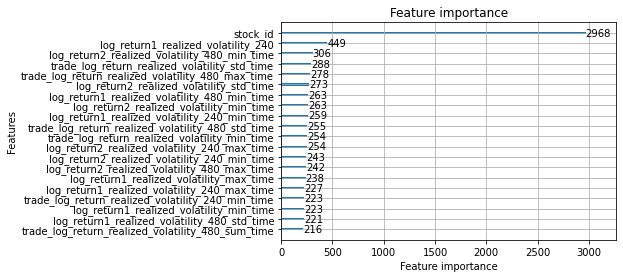

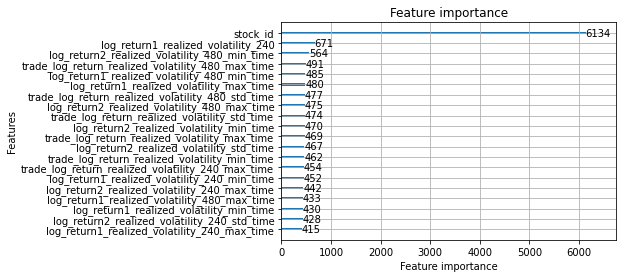

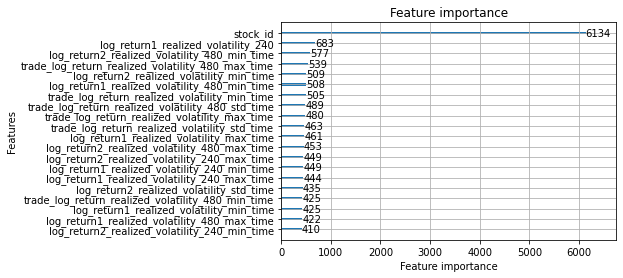

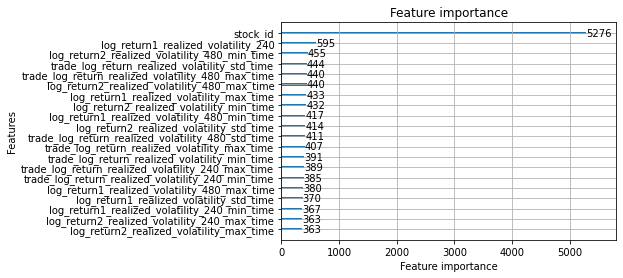

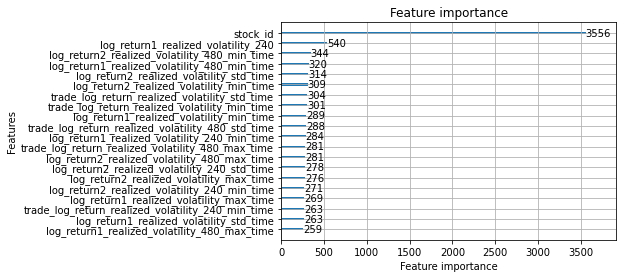

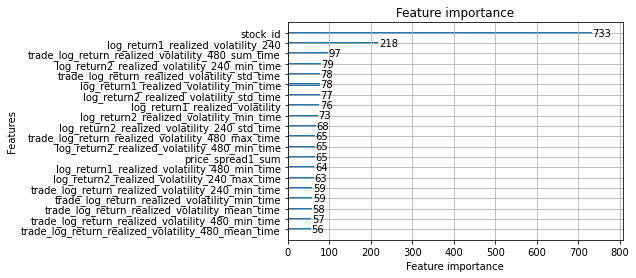

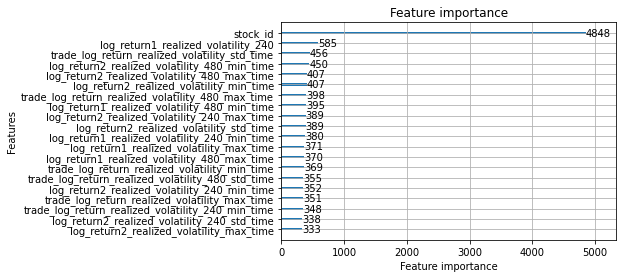

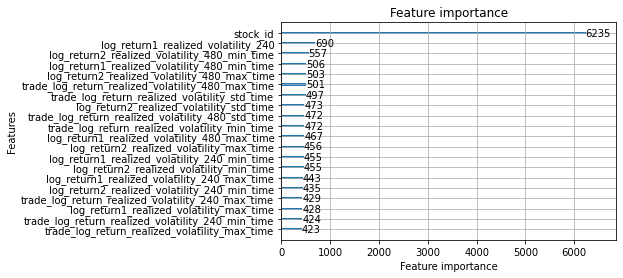

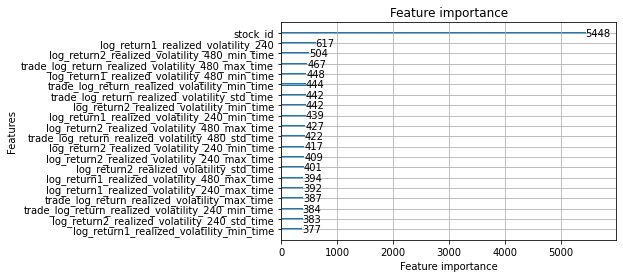

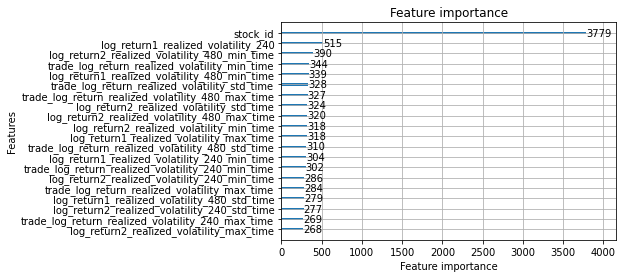

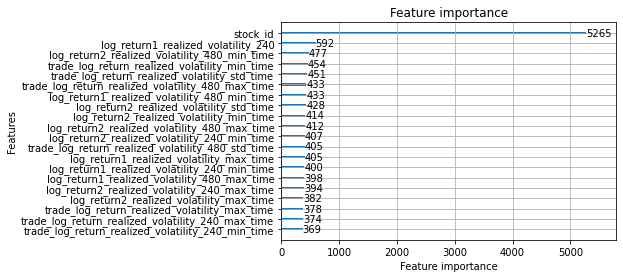

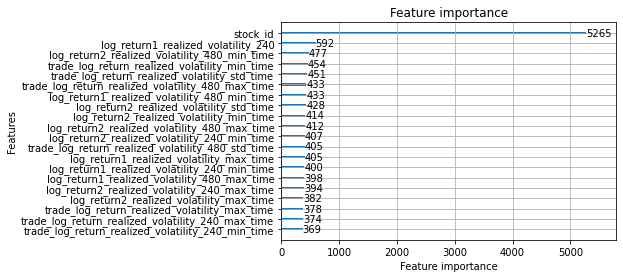

In [17]:
# Traing and evaluate
predictions_lgb= train_and_evaluate_lgb(train, test,params0)
test['target'] = predictions_lgb
test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [18]:
test[['row_id', 'target']].to_csv('submission.csv',index = False)

In [19]:
xf = pd.read_csv('./submission.csv')
xf

,row_id,target
0,0-4,0.003387
1,0-32,0.003239
2,0-34,0.003239
